# Ford Fiesta Price Prediction Using Linear Regression Model

**Goal:** Build a simple linear regression model to predict Ford Fiesta prices based on mileage and trim level.

**Dataset:** Used Ford Fiestas scraped from cars.com

**Model:** Multiple Linear Regression

## Step 1: Import Libraries

First, let's import all the libraries needed for analysis and modeling.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Step 2: Load the Data

Load Ford Fiesta dataset and take a first look at it.

The data was scraped from a cars.com search for used ford fiesta of any distance from Denver, CO. It was already cleaned and extrapolated using the scripts in this repo AND I also just went in and deleted a listing that had zero miles and also manually adjusted some of the trims with unnecessary detail.

In [2]:
# Load the data
df = pd.read_csv('ford_fiestas_extrap.csv')

# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Basic info
print("\nDataset shape:", df.shape)
print("\nColumn names and types:")
print(df.info())

First 5 rows of the dataset:
                 title  price  mileage                            location  \
0  2017 Ford Fiesta SE   6990    64372               Miami, FL (1,716 mi.)   
1  2019 Ford Fiesta SE   8119    92119           Springfield, MO (658 mi.)   
2  2015 Ford Fiesta SE   6987   117862              Muskegon, MI (998 mi.)   
3  2016 Ford Fiesta ST  10989   100423           Springfield, MO (658 mi.)   
4  2019 Ford Fiesta SE   8435    71117  North Richland Hills, TX (644 mi.)   

   year trim state  distance  
0  2017   SE    FL      1716  
1  2019   SE    MO       658  
2  2015   SE    MI       998  
3  2016   ST    MO       658  
4  2019   SE    TX       644  

Dataset shape: (670, 8)

Column names and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     670 non-null    object
 1   price     670 non-null    int64 
 2   milea

## Step 3: Data Exploration

Before building the model, let's understand the key variables: **price**, **mileage**, and **trim**.

In [3]:
# Summary statistics for numeric columns
print("Summary Statistics:")
print(df[['price', 'mileage']].describe())

# Check for missing values
print("\nMissing values:")
print(df[['price', 'mileage', 'trim']].isnull().sum())

# Check unique trim levels
print("\nTrim levels and their counts:")
print(df['trim'].value_counts())

Summary Statistics:
              price        mileage
count    670.000000     670.000000
mean    8372.323881   88035.198507
std     3018.306661   35234.569199
min     1200.000000     890.000000
25%     5998.000000   64050.250000
50%     7995.000000   84842.500000
75%     9999.000000  110222.500000
max    19999.000000  209211.000000

Missing values:
price      0
mileage    0
trim       0
dtype: int64

Trim levels and their counts:
trim
SE          468
S            89
ST           70
Titanium     22
ST Line       8
SES           7
SEL           6
Name: count, dtype: int64


### Visualize the Distributions

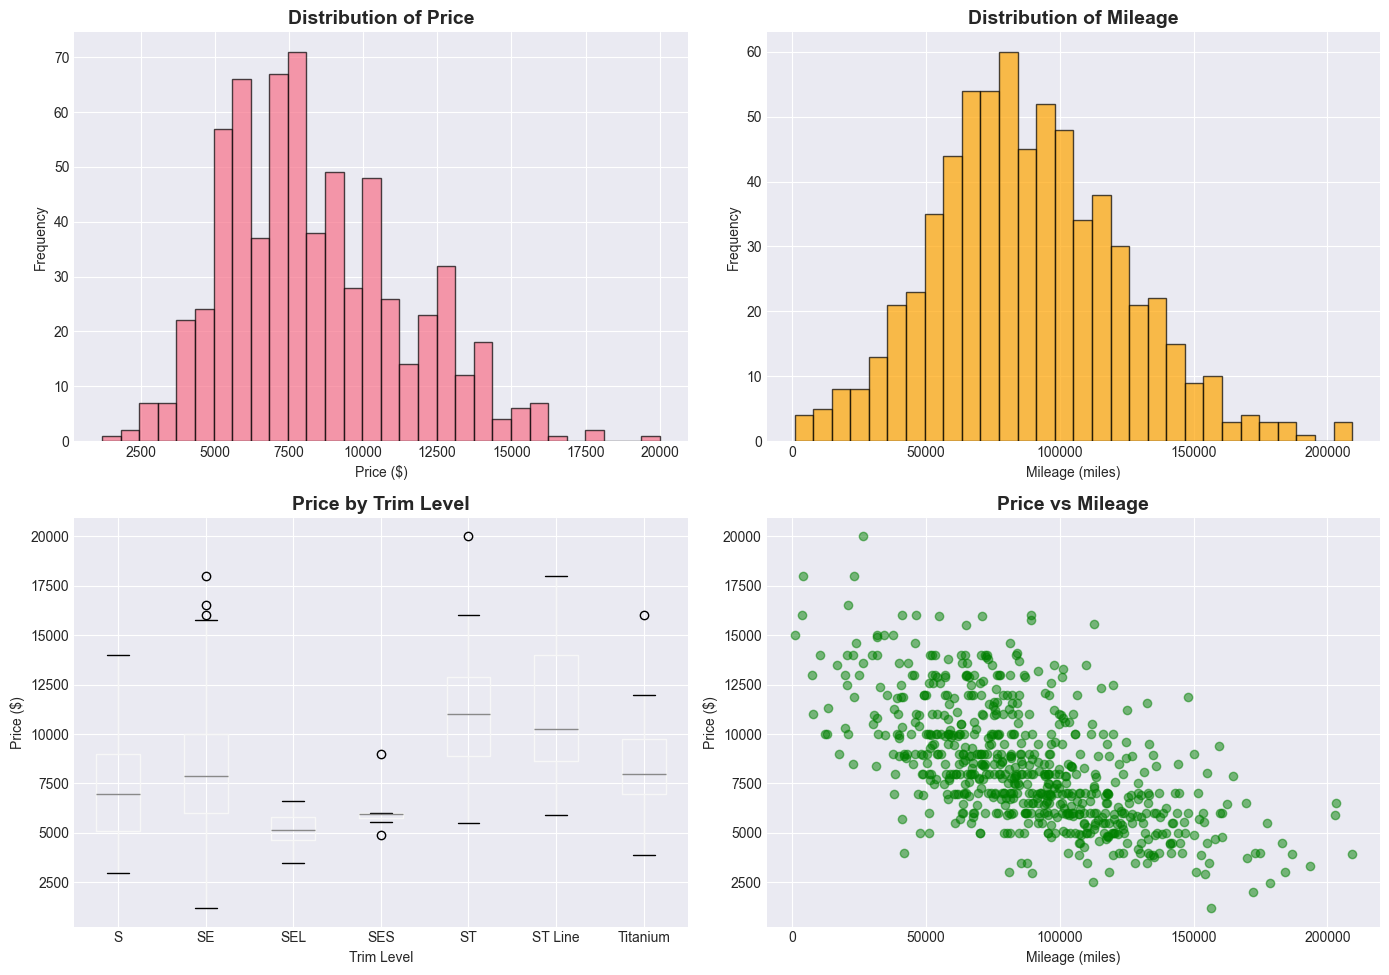

In [4]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
axes[0, 0].hist(df['price'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Price', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')

# Mileage distribution
axes[0, 1].hist(df['mileage'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Distribution of Mileage', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mileage (miles)')
axes[0, 1].set_ylabel('Frequency')

# Price by trim level (boxplot)
df.boxplot(column='price', by='trim', ax=axes[1, 0])
axes[1, 0].set_title('Price by Trim Level', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Trim Level')
axes[1, 0].set_ylabel('Price ($)')
plt.suptitle('')  # Remove automatic title

# Scatter: Price vs Mileage
axes[1, 1].scatter(df['mileage'], df['price'], alpha=0.5, color='green')
axes[1, 1].set_title('Price vs Mileage', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Mileage (miles)')
axes[1, 1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

### Check Correlation

Correlation Matrix:
           price  mileage
price    1.00000 -0.60616
mileage -0.60616  1.00000


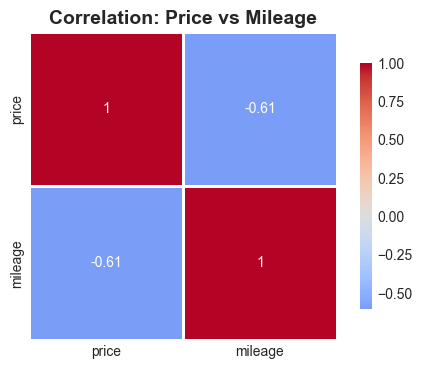

In [5]:
# Calculate correlation between price and mileage
correlation = df[['price', 'mileage']].corr()
print("Correlation Matrix:")
print(correlation)

# Visualize with heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation: Price vs Mileage', fontsize=14, fontweight='bold')
plt.show()

## Step 4: Data Preparation

Now to prepare the data for modeling:
1. Handle any missing values
2. Select the features (X) and target (y)
3. Split into training and testing sets

In [6]:
# Remove any rows with missing values in our key columns
df_clean = df[['price', 'mileage', 'trim']].dropna()

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Rows removed: {len(df) - len(df_clean)}")

Original dataset size: 670
Clean dataset size: 670
Rows removed: 0


In [7]:
# Define features (X) and target (y)
X = df_clean[['mileage', 'trim']]
y = df_clean['price']

print("Features (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())

Features (X):
   mileage trim
0    64372   SE
1    92119   SE
2   117862   SE
3   100423   ST
4    71117   SE

Target (y):
0     6990
1     8119
2     6987
3    10989
4     8435
Name: price, dtype: int64


In [8]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 536 samples
Testing set size: 134 samples


## Step 5: Build the Linear Regression Model

This uses a **Pipeline** to one-hot encode the categorical 'trim' variable and train a linear regression model

In [9]:
# Create preprocessing pipeline
# One-hot encode 'trim', leave 'mileage' as numeric
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['mileage']),  # Keep mileage as-is
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['trim'])  # One-hot encode trim
    ]
)

# Create the full pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print("Pipeline created successfully!")
print(model)

Pipeline created successfully!
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['mileage']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['trim'])])),
                ('regressor', LinearRegression())])


## Step 6: Train the Model

Fit the model on the training data.

In [10]:
# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("✅ Model trained successfully!")

Training the model...
✅ Model trained successfully!


## Step 7: Make Predictions

Use the trained model to make predictions on both training and test sets.

In [11]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Show some example predictions
comparison = pd.DataFrame({
    'Actual Price': y_test.values[:10],
    'Predicted Price': y_test_pred[:10],
    'Difference': y_test.values[:10] - y_test_pred[:10]
})

print("Sample Predictions (first 10 test samples):")
print(comparison)

Sample Predictions (first 10 test samples):
   Actual Price  Predicted Price   Difference
0          4794      7596.058199 -2802.058199
1         10000     10430.892819  -430.892819
2          8995     10851.499418 -1856.499418
3          7741      8967.689632 -1226.689632
4          9495      8857.396153   637.603847
5          8400     11135.265997 -2735.265997
6          3300      2377.116482   922.883518
7          9500     11064.508119 -1564.508119
8          6699      8606.102757 -1907.102757
9          9998      6172.652219  3825.347781


/Users/jefferylane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jefferylane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jefferylane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


## Step 8: Evaluate Model Performance

Assess how well the model performs using several metrics:
- **R² Score**: Proportion of variance explained (0-1, higher is better)
- **Mean Absolute Error (MAE)**: Average absolute difference in dollars
- **Root Mean Squared Error (RMSE)**: Penalizes larger errors more

In [12]:
# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate metrics for test set
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display results
print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print("\nTRAINING SET:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  Mean Absolute Error: ${train_mae:.2f}")
print(f"  Root Mean Squared Error: ${train_rmse:.2f}")

print("\nTEST SET:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  Mean Absolute Error: ${test_mae:.2f}")
print(f"  Root Mean Squared Error: ${test_rmse:.2f}")
print("=" * 50)

# Interpretation
print("\n📊 INTERPRETATION:")
print(f"The model explains {test_r2*100:.1f}% of the variance in price.")
print(f"On average, predictions are off by ${test_mae:.2f}.")

MODEL PERFORMANCE METRICS

TRAINING SET:
  R² Score: 0.5239
  Mean Absolute Error: $1583.79
  Root Mean Squared Error: $2075.88

TEST SET:
  R² Score: 0.4865
  Mean Absolute Error: $1656.38
  Root Mean Squared Error: $2179.94

📊 INTERPRETATION:
The model explains 48.7% of the variance in price.
On average, predictions are off by $1656.38.


## Step 9: Visualize Model Performance

Visualize how well the predictions match the actual prices.

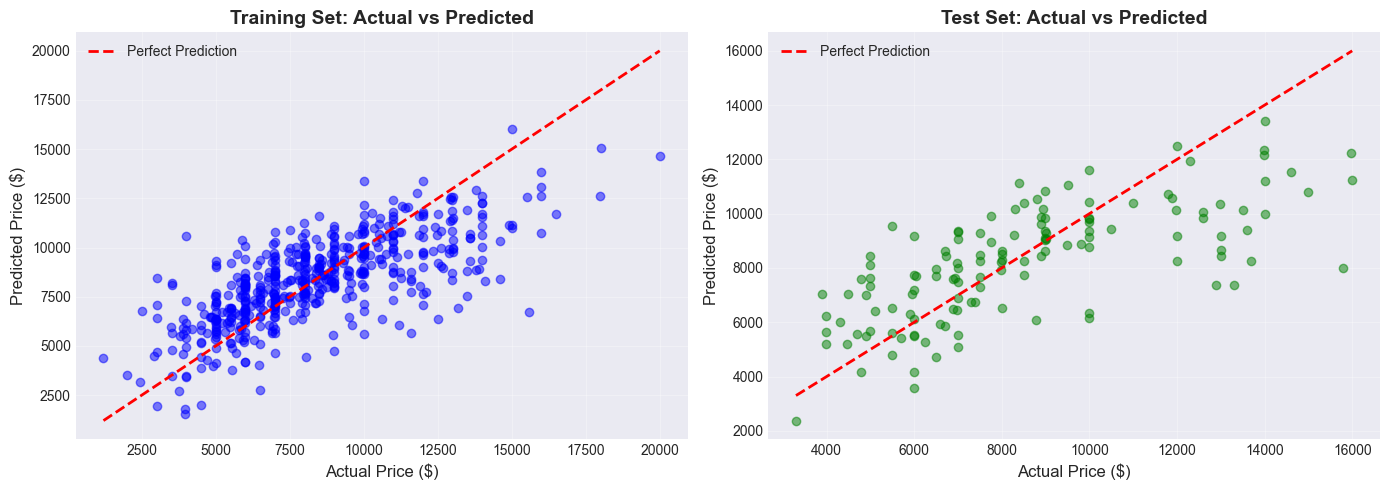

In [13]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Actual vs Predicted (Training)
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title('Training Set: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Test)
axes[1].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
axes[1].set_title('Test Set: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residual Plot

Residuals show the errors (actual - predicted). Ideally, they should be randomly scattered around zero.

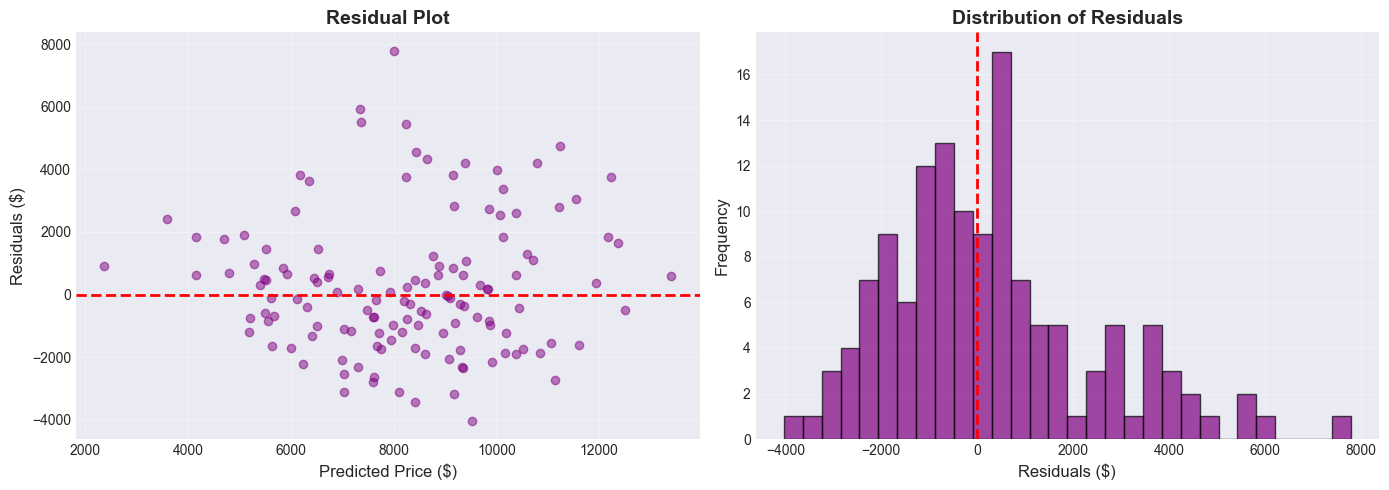

In [14]:
# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual scatter plot
axes[0].scatter(y_test_pred, residuals, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0].set_ylabel('Residuals ($)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('Residuals ($)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 10: Interpret the Model Coefficients

Analyzing the actual coefficients to understand how mileage and trim affect price.

In [15]:
# Extract the trained linear regression model
lr_model = model.named_steps['regressor']

# Get feature names after preprocessing
feature_names = ['mileage'] + list(model.named_steps['preprocessor']
                                   .named_transformers_['cat']
                                   .get_feature_names_out(['trim']))

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\nMODEL COEFFICIENTS:")
print("=" * 50)
print(coefficients)
print(f"\nIntercept: ${lr_model.intercept_:.2f}")
print("=" * 50)


MODEL COEFFICIENTS:
         Feature  Coefficient
5   trim_ST Line  4390.561322
4        trim_ST  4165.613176
6  trim_Titanium  1320.937731
1        trim_SE   937.022201
3       trim_SES   180.869316
0        mileage    -0.054025
2       trim_SEL  -209.302914

Intercept: $11890.13


### What do these coefficients mean?

- **Mileage coefficient**: For every additional mile, the price changes by this amount
- **Trim coefficients**: These show the price premium/discount for each trim compared to the baseline trim (the one that was dropped)
- **Intercept**: The baseline price when all features are zero (not directly interpretable here)

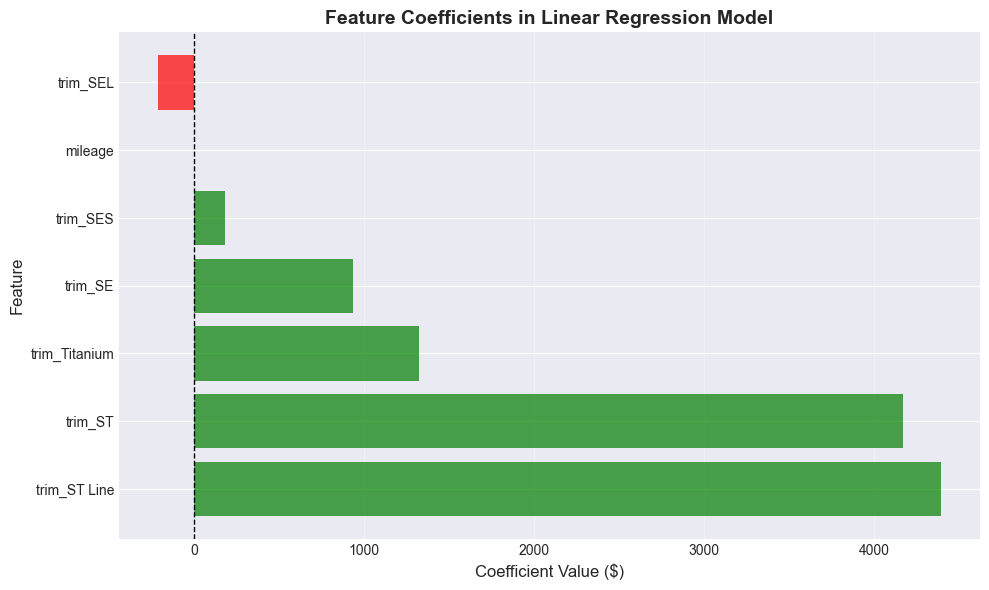

In [16]:
# Visualize coefficients
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value ($)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Coefficients in Linear Regression Model', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Step 11: Make a Prediction for a New Car

Test the model by predicting the price of a hypothetical Ford Fiesta.

In [17]:
# Create a new car to predict
new_car = pd.DataFrame({
    'mileage': [75000],
    'trim': ['SE']
})

# Make prediction
predicted_price = model.predict(new_car)[0]

print("\n🚗 NEW CAR PREDICTION:")
print("=" * 50)
print(f"Car: Ford Fiesta {new_car['trim'].values[0]}")
print(f"Mileage: {new_car['mileage'].values[0]:,} miles")
print(f"Predicted Price: ${predicted_price:.2f}")
print("=" * 50)


🚗 NEW CAR PREDICTION:
Car: Ford Fiesta SE
Mileage: 75,000 miles
Predicted Price: $8775.31


## Step 12: Summary and Next Steps

### Model Summary

**Multiple Linear Regression** model predicting Ford Fiesta prices using:
- **Mileage** (numeric)
- **Trim** (categorical)

### Key Findings
- The model will show which trim levels command higher prices
- It can quantify exactly how much value a car loses per mile driven
- The model provides interpretable coefficients

### Limitations
1. **Only 2 features**: It's ignoring year, location, and other important factors
2. **Linear assumption**: Assumes relationships are linear, which might not be true.
3. **No interactions**: Doesn't capture if the effect of mileage differs by trim
4. **Potential outliers**: Extreme values can skew the model

### Future Improvements
1. **Add more features**: Include year, location, dealer type
2. **Feature engineering**: Create interactions (e.g., mileage × trim)
3. **Try other models**: Random Forest, Gradient Boosting
4. **Handle outliers**: Remove or transform extreme values
5. **Cross-validation**: Use k-fold CV for more robust evaluation